In [ ]:
!pip install sqlalchemy psycopg2-binary pandas wordcloud > /dev/null 2>&1

In [10]:
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import unicodedata
import math
import os
import matplotlib.patches as mpatches
import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import text
from tqdm import tqdm
from collections import Counter
import unicodedata
import re

In [2]:
user = "sy91dhb"
password = "g5t49ao"
host = "178.156.142.230"
port = "5432"
db = "hd64m1ki"

engine = create_engine(f"postgresql+psycopg2://{user}:{password}@{host}:{port}/{db}")

In [3]:
def display_df(df):
    with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', None):
        display(df)

## Sneak Peak at the Data

In [5]:
display_df(pd.read_sql("SELECT * FROM hacker_news.items LIMIT 10;", engine))

,id,dead,type,by,time,text,parent,kids,url,score,title,descendants
0,24434644,None,comment,mastax,2020-09-10 18:38:22,AMD has said in the past that the GPUs will be available before the new consoles. I&#x27;d expect very limited availability sometime early November. CPUs maybe a bit earlier and a bit better availability.,24433817.0,None,None,NaN,None,None
1,24434645,None,comment,scns,2020-09-10 18:38:27,"They look pretty good, check out the benchmarks:\n<a href=""https:&#x2F;&#x2F;www.anandtech.com&#x2F;show&#x2F;15578&#x2F;cloud-clash-amazon-graviton2-arm-against-intel-and-amd"" rel=""nofollow"">https:&#x2F;&#x2F;www.anandtech.com&#x2F;show&#x2F;15578&#x2F;cloud-clash-amazon-grav...</a>",24433529.0,None,None,NaN,None,None
2,24434646,None,comment,MurMan,2020-09-10 18:38:30,"I&#x27;m a San Diego resident that was falsely accused of a serious offense a few years ago. Surveillance footage from a restaurant saved me from prosecution.<p>I know that this is a minority opinion, but I&#x27;m in favor of cameras in public places. There will always be the potential for abuse even with strong restrictions, but I think the benefits are worth it.",24433668.0,"[24435100, 24435050, 24435762, 24434868, 24435830, 24434872, 24434815, 24437634, 24435055, 24435903, 24435203]",None,NaN,None,None
3,24434647,None,comment,macrael,2020-09-10 18:38:31,"10 years ago (!) Instapaper changed its tune and started requiring emails for new accounts. Before it had not required emails (just usernames) and even didn&#x27;t require passwords, and after living with that for years Marco decided to switch back to the more traditional form.<p><a href=""https:&#x2F;&#x2F;blog.instapaper.com&#x2F;post&#x2F;2318776738"" rel=""nofollow"">https:&#x2F;&#x2F;blog.instapaper.com&#x2F;post&#x2F;2318776738</a><p>It&#x27;s interesting to think that times may have changed and that people are hesitant to give out their email addresses anymore, but you are giving up some real benefits by leaving it out.",24433090.0,None,None,NaN,None,None
4,24434648,None,comment,whateveracct,2020-09-10 18:38:34,"I think plenty of people will just wear masks in public in general going forward. There&#x27;s really barely any downside. If anything, hiding my face in public &amp; making me less approachable is worth it without the health benefits!",24434621.0,"[24436800, 24435419]",None,NaN,None,None
5,24434649,True,story,kvrichard,2020-09-10 18:38:36,None,NaN,None,https://medium.com/human-centered-thinking-switzerland/communication-for-designers-ddbaae0df62a,1.0,Communication For Designers – When communication is conflated with “sales pitch”,None
6,24434650,None,comment,edumucelli,2020-09-10 18:38:41,"One more than &quot;good&quot;, actually phenomenal thing about LetsEncrypt from my experience is their community. It is pure gold. People are super helpful in the <a href=""https:&#x2F;&#x2F;community.letsencrypt.org&#x2F;"" rel=""nofollow"">https:&#x2F;&#x2F;community.letsencrypt.org&#x2F;</a> forum. I had issues on setting it up and lots of people got involved and helped me out, the responsiveness, the cordiality, that is high quality &quot;support&quot; that no money can pay.",24430260.0,None,None,NaN,None,None
7,24434651,None,comment,gotostatement,2020-09-10 18:38:42,nice work!,24434165.0,None,None,NaN,None,None
8,24434652,None,comment,fl0wrini,2020-09-10 18:38:43,"Haha! Using Thoreau&#x27;s essays to defend rioters and looters plus criminals being killed by &quot;racist policing...&quot; Welcome to the internet, where the real problem is. A place where one criminal&#x27;s death (2.9e-10 of the population) can be glorified and shared as fuel to spark outrage amongst entire cities to destroy innocent people&#x27;s lives and homes.",24427724.0,[24435969],None,NaN,None,None
9,24434653,None,comment,chrisjs96,2020-09-10 18:38:46,It&#x27;s not healthy long term though because humans have to exchange bacteria and get sick.,24434554.0,[24434728],None,NaN,None,None


In [6]:
display_df(pd.read_sql("SELECT * FROM hacker_news.users LIMIT 10;", engine))

,id,created,karma,about,submitted
0,_------------_,2018-10-30 22:25:25,5,None,"[18723436, 18710285, 18341881]"
1,_-----_,2022-12-07 19:45:14,38,None,"[34353215, 34346450, 34314090, 34277524, 34262511, 34259647, 34239938, 34236652, 34236445, 34235992, 34199795, 34137505, 34114262, 34105849, 33945079, 33945054, 33926931, 33915446, 33915425]"
2,_--,2016-08-27 21:06:13,-1,None,"[12390950, 12390899, 12373932]"
3,_---____--_--,2022-03-17 12:35:53,6,None,[30710444]
4,_--_,2014-08-02 11:52:04,-7,None,"[10919437, 8668545, 8349770, 8335037]"
5,_--_----_--_,2011-08-09 00:17:37,5,just wandering around,"[3057854, 2936170, 2881969, 2861960]"
6,_--__--__,2020-02-24 17:36:53,21,None,"[41506632, 41207475, 33171311, 31927691, 31927690, 29008735, 25444819, 22407983]"
7,_--___-___,2019-07-09 20:49:22,11,None,"[24152556, 23797608, 22321065, 22239248, 21973585, 21970978, 21714827, 21696737, 21576081, 20867986, 20748802]"
8,_-_-_-,2013-10-18 00:43:28,-20,,"[6569743, 6569721, 6569642, 6569580, 6569556, 6569529, 6569497, 6569491, 6568948]"
9,_-_-_-_,2015-02-10 08:08:56,12,,"[9204764, 9204535, 9105003, 9088165]"


## Stories and comments

In [37]:
display_df(pd.read_sql("SELECT type, count(*) FROM hacker_news.items GROUP BY type;", engine))

,type,count
0,comment,35731362
1,job,17001
2,poll,2113
3,pollopt,14721
4,story,5351748


In [6]:
display_df(pd.read_sql("SELECT * FROM hacker_news.items WHERE type='story' LIMIT 10;", engine))

,id,dead,type,by,time,text,parent,kids,url,score,title,descendants
0,36679708,None,story,possiblelion,2023-07-11 12:55:54,None,None,[36680109],https://www.nif.fund/,1,NATO Innovation Fund launched today,1
1,36679710,None,story,todsacerdoti,2023-07-11 12:56:12,None,None,None,https://www.revsys.com/tidbits/pytest-fixtures-are-magic/,3,Pytest Fixtures Are Magic,0
2,37228812,None,story,reset2023,2023-08-22 22:33:42,"Whatever happened to supersonic commercial flights? It takes so long to get anywhere on an airplane and it 2023, their speed is still the same as 80 years ago.",None,"[37234090, 37238184, 37231474, 37252738, 37228876, 37228986, 37240705, 37230332]",None,9,Why are commercial airplanes still so slow?,18
3,37228814,None,story,mrcjkb,2023-08-22 22:33:51,None,None,None,https://mrcjkb.dev/posts/2023-08-22-setup.html,4,Rethinking the `setup` convention in Neovim. Is it time for a paradigm shift?,0
4,36230065,None,story,nohaydeprobleme,2023-06-07 18:28:01,None,None,None,https://journalistsresource.org/home/solitary-confinement-research-primer/,1,Solitary confinement in US prisons: A research-based primer,0
5,36230074,None,story,mort96,2023-06-07 18:28:29,None,None,[36230105],https://github.com/fractureiser-investigation/fractureiser,4,Modded Minecraft Malware “Fractureiser” – What We Know,2
6,36230077,None,story,PaulHoule,2023-06-07 18:28:39,None,None,None,https://www.theguardian.com/uk-news/2023/jun/06/met-police-operation-secretly-monitors-children-online,2,Met police office monitors children online,0
7,36230078,None,story,m-watson,2023-06-07 18:28:58,None,None,"[36235040, 36230085, 36230279, 36230635, 36232270]",https://phys.org/news/2023-06-morals-declining.html,6,"Think morals are declining? So has everyone, ever, study says",4
8,35680628,None,story,triyambakam,2023-04-23 22:07:40,"I&#x27;m considering using LangChain, LlamaIndex, etc. but wondering what others&#x27; experiences have been with the various approaches. I have a custom corpus of documentation for which I want to create a question-answer chatbot.",None,"[35683816, 35682268]",None,6,Ask HN: What is your set up for using LLMs for documentation question answering?,4
9,34734143,None,story,luu,2023-02-10 00:56:51,None,None,"[34761970, 34759697]",https://perso.ens-lyon.fr/jean-michel.muller/advertising.pdf,34,Advertising tips for computer number system designers (2021) [pdf],5


### What are jobs?

In [39]:
display_df(pd.read_sql("SELECT * FROM hacker_news.items WHERE type='job' LIMIT 3;", engine))

,id,dead,type,by,time,text,parent,kids,url,score,title,descendants
0,5600012,None,job,jaf12duke,2013-04-24 06:28:51,"At 42Floors we still don’t have traditional job titles. As our company has grown, we keep attracting more entrepreneurs who themselves have never cared about job titles. We’re now at 14 people, and we still don’t really have any hierarchy in the company; so there is not really a need to embrace a lot of formal organization.<p>A little while ago, we did implement some processes to keep creative anarchy and functional teamwork in balance. But hierarchy and job titles still didn’t emerge.<p>In fact, the only reason we have job titles on our open positions is that the rest of the world kind of expects them; but once you get here, we don’t really care. We’re a startup. Everyone wears multiple hats. Smart people will do awesome stuff if given the freedom to figure it out.<p>We’d love for you to come check us out. If you want to write Ruby or Backbone.js, or manage a sales pipeline or talk commercial real estate, we might have a job title that’s right for you.<p>http://42floors.com/jobs<p>42Floors\nCreating the world's easist way to search for office space.",None,None,None,1.0,"Job titles, shmob titles",None
1,3700018,None,job,None,2012-03-13 19:41:48,None,None,None,None,NaN,None,None
2,6050035,None,job,londont,2013-07-16 05:32:23,"About us:<p>+ We&#x27;re building the future of payroll. If you love solving un-sexy, foundational problems that affect millions of people, we&#x27;d love to talk with you. Current payroll products haven&#x27;t changed in decades and customers deserve better.<p>+ Our founders are second time entrepreneurs from Stanford who have had two prior exits. We&#x27;re hungry to build something truly great and we&#x27;re in this for the long haul.<p>+ We&#x27;re funded by Y Combinator, Google Ventures, and some of the most prominent CEOs in Silicon Valley (Yelp, Yammer, Box, Dropbox, Parse, salesforce and more).<p>+ Most importantly, our company values are here: https:&#x2F;&#x2F;zenpayroll.com&#x2F;about.<p>--------------------------------------------------------------------------------<p>Things we&#x27;re looking for:<p>+ Experience with Rails | Backbone.js | CoffeeScript | MySQL is a plus but not a pre-requisite.<p>+ Interest in using a test driven development process. We also pair part of the time.<p>+ Interest in building user-facing and core-backend features, as well as being an active part of the design process.<p>+ Desire to understand the customer perspective. All members of our team are builders and it&#x27;s important everyone understands the pain point we&#x27;re solving.<p>--------------------------------------------------------------------------------<p>Perks:<p>+ You&#x27;ll be a core member of our team as we grow the company. As a result, you&#x27;ll receive a competitive salary + significant equity stake.<p>+ Housing stipend if you live near the office, three meals a day, company retreats, gym&#x2F;sports club stipend, dream work set-up, and more -- including copious espressos brewed by one of our co-founders. People are the foundation of our company and we make sure they know they&#x27;re valued.<p>--------------------------------------------------------------------------------<p>Above all, we&#x27;re looking for individuals who are yearning to do the best work of their lives. You&#x27;ll be amply rewarded for the work you do.<p>--------------------------------------------------------------------------------<p>To apply, send a note to jobs [at] zenpayroll [dot] com and include your LinkedIn, GitHub, and&#x2F;or any project pages.<p>This job is located in SoMa, San Francisco, CA. You must be local or willing to relocate (we&#x27;ll cover the cost).",None,None,None,1.0,ZenPayroll (YC W12) is hiring Rails engineers to help make delightful payroll,None


### What are polls?

In [40]:
display_df(pd.read_sql("SELECT * FROM hacker_news.items WHERE type='poll' LIMIT 3;", engine))

,id,dead,type,by,time,text,parent,kids,url,score,title,descendants
0,2400020,None,poll,None,2011-04-02 16:01:37,None,None,None,None,NaN,None,NaN
1,800047,None,poll,RiderOfGiraffes,2009-09-02 14:15:12,"Following on from the raw question and its link to some text of explanation, \nhttp://news.ycombinator.com/item?id=799934\nI've remember I can create a poll ...",None,"[800155, 800101]",None,12.0,"Poll: Horizontal, Vertical, Mixed, Other?",2.0
2,550110,None,poll,khangtoh,2009-04-07 03:10:04,"Just wondering how many applicants are planning to move to San Francisco or Denver/Colorado to start up your dream regardless getting accepted into YC/TechStars?<p>We are in the process of selling our house and planning to move out west end of April. We'll be driving cross country from Indiana! Maybe we'll blog along our way using our IPhones!<p>I heard Colorado has a tech scene brewing, so we're considering that as well.",None,"[550356, 550406]",None,4.0,Poll: Move to SF or Colorado?,2.0


In [41]:
display_df(pd.read_sql("SELECT * FROM hacker_news.items WHERE type='pollopt' LIMIT 3;", engine))

,id,dead,type,by,time,text,parent,kids,url,score,title,descendants
0,5900000,None,pollopt,will_brown,2013-06-18 16:56:27,Facebook Email,None,None,None,0,None,None
1,5900001,None,pollopt,will_brown,2013-06-18 16:56:27,Facebook Hardware,None,None,None,0,None,None
2,5900002,None,pollopt,will_brown,2013-06-18 16:56:27,Other,None,None,None,1,None,None


In [7]:
print("Number of stories:", pd.read_sql("SELECT count(*) FROM hacker_news.items WHERE type='story';", engine).iloc[0, 0])

Number of stories: 5351748


In [8]:
print("Number of comments:", pd.read_sql("SELECT count(*) FROM hacker_news.items WHERE type='comment';", engine).iloc[0, 0])

Number of comments: 35731362


In [61]:
display_df(pd.read_sql("SELECT * FROM hacker_news.items WHERE type='story' AND by IS NULL AND title IS NOT NULL LIMIT 10;", engine))

,id,dead,type,by,time,text,parent,kids,url,score,title,descendants


In [15]:
display_df(pd.read_sql("SELECT * FROM hacker_news.items WHERE type='story' AND score IS NULL LIMIT 10;", engine))

,id,dead,type,by,time,text,parent,kids,url,score,title,descendants
0,41383253,True,story,None,2024-08-28 20:27:04,None,None,None,None,None,None,None
1,40535013,None,story,None,2024-05-31 14:40:18,None,None,None,None,None,None,None
2,39787362,None,story,None,2024-03-22 04:02:23,None,None,None,None,None,None,None
3,39787374,None,story,None,2024-03-22 04:05:13,None,None,None,None,None,None,None
4,8241435,None,story,None,2014-08-29 08:07:39,None,None,None,None,None,None,None
5,39837663,None,story,None,2024-03-27 11:20:11,None,None,None,None,None,None,None
6,40933749,None,story,None,2024-07-11 05:45:29,None,None,None,None,None,None,None
7,39697004,None,story,None,2024-03-13 20:26:07,None,None,None,None,None,None,None
8,40434377,True,story,None,2024-05-21 22:41:25,None,None,None,None,None,None,None
9,39697055,None,story,None,2024-03-13 20:30:30,None,None,None,None,None,None,None


In [20]:
display_df(pd.read_sql("SELECT * FROM hacker_news.items WHERE type='story' AND score IS NULL AND title IS NOT NULL LIMIT 10;", engine))

,id,dead,type,by,time,text,parent,kids,url,score,title,descendants


In [21]:
display_df(pd.read_sql("SELECT * FROM hacker_news.items WHERE type='story' AND score IS NOT NULL AND title IS NULL LIMIT 10;", engine))

,id,dead,type,by,time,text,parent,kids,url,score,title,descendants
0,13753887,True,story,_cv7i,2017-02-28 14:21:27,None,None,None,None,1,None,None
1,13356490,True,story,Perados,2017-01-09 14:27:41,None,None,"[13356871, 13356905, 13356860, 13356518, 13356789, 13356721, 13356940, 13356955, 13356930, 13356867, 13356901, 13356780, 13357055, 13356735, 13356879, 13357150, 13357023, 13356943]",None,22,None,None
2,13706876,True,story,RKoutnik,2017-02-22 16:48:46,None,None,"[13707261, 13707313]",None,12,None,None
3,14056765,True,story,oskarth,2017-04-07 04:04:51,None,None,"[14057019, 14056927, 14057010]",None,30,None,None
4,14462227,True,story,yeukhon,2017-06-01 18:11:40,None,None,"[14462660, 14462268, 14462473, 14462342, 14462890, 14464354, 14463558, 14463190, 14462246, 14463588]",None,3,None,None
5,12293003,True,story,MollyR,2016-08-15 21:06:32,None,None,"[12294696, 12294565]",None,19,None,None
6,13565872,True,story,_g2lm,2017-02-04 06:04:20,None,None,"[13566063, 13566017, 13566085, 13566002, 13566006]",None,10,None,None
7,12716825,True,story,drewrv,2016-10-16 05:03:49,None,None,"[12716854, 12717635, 12717158, 12716877, 12717496, 12718510, 12717730, 12716902, 12718518, 12716852, 12718639, 12717509, 12716927, 12716941, 12718204, 12716937, 12716888, 12717248, 12717489, 12716966, 12717613, 12718362, 12717912, 12716887, 12716897, 12719004, 12716896, 12719211, 12718345, 12718631, 12721885, 12718366, 12718006, 12716978, 12718081, 12718333, 12719078, 12717009, 12717245, 12718881, 12719414, 12716904, 12717720, 12718533, 12719430, 12716875, 12716923, 12717742, 12718741, 12717669, 12716857, 12716860, 12717828, 12716832, 12718902, 12717075, 12717586, 12717010, 12716853, 12717145, 12717045, 12717596, 12717277, 12718163]",None,463,None,None
8,13967891,True,story,scholles,2017-03-27 15:20:00,None,None,[14010541],None,3,None,None
9,12921154,True,story,bringking,2016-11-10 15:29:25,None,None,"[12921285, 12921300, 12921291, 12921260, 12921313]",None,5,None,None


In [18]:
display_df(pd.read_sql("SELECT * FROM hacker_news.items WHERE type='comment' AND text IS NULL LIMIT 10;", engine))

,id,dead,type,by,time,text,parent,kids,url,score,title,descendants
0,41583295,None,comment,None,2024-09-18 18:59:45,None,41583224,None,None,None,None,None
1,41783401,None,comment,None,2024-10-09 01:52:43,None,41782898,None,None,None,None,None
2,40135264,None,comment,None,2024-04-23 19:19:41,None,40134674,None,None,None,None,None
3,41034026,None,comment,None,2024-07-22 14:17:30,None,41033705,None,None,None,None,None
4,40884685,None,comment,None,2024-07-05 18:53:44,None,40884356,None,None,None,None,None
5,29516954,None,comment,None,2021-12-10 23:55:49,None,29514110,None,None,None,None,None
6,40384916,None,comment,None,2024-05-17 01:09:49,None,40384880,None,None,None,None,None
7,40384918,None,comment,None,2024-05-17 01:09:54,None,40384489,None,None,None,None,None
8,40384933,None,comment,None,2024-05-17 01:12:01,None,40384081,None,None,None,None,None
9,40384934,None,comment,None,2024-05-17 01:12:02,None,40384838,None,None,None,None,None


## Distribution of scores

In [9]:
df_scores = pd.read_sql("SELECT score FROM hacker_news.items WHERE type='story';", engine)

In [14]:
print("Number of stories with null scores:", df_scores['score'].isnull().sum())

Number of null values in df_scores: 235541


In [35]:
hist = df_scores['score'].value_counts().sort_index()
with pd.option_context('display.max_rows', 30):
    display(hist.reset_index())

,score,count
0,-1.0,1
1,0.0,1453
2,1.0,2324020
3,2.0,1034541
4,3.0,484385
...,...,...
1877,4489.0,1
1878,4549.0,1
1879,5710.0,1
1880,5771.0,1


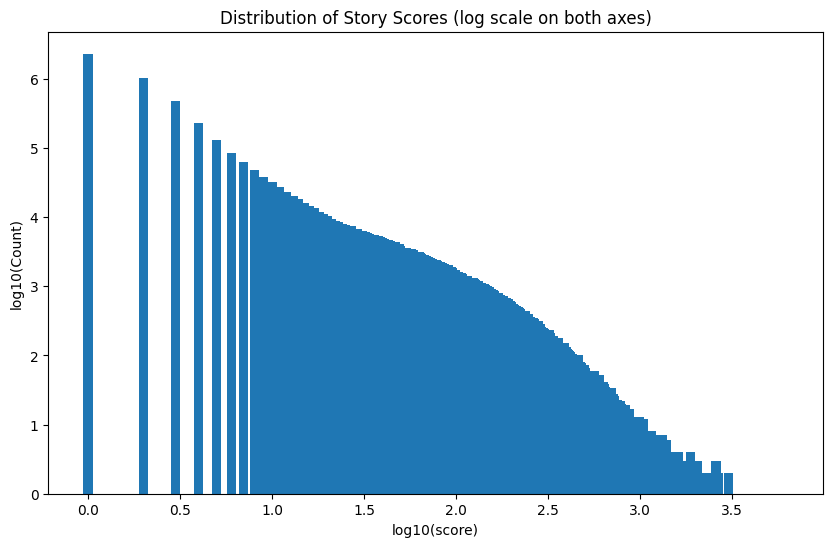

In [31]:
# Filter out non-positive scores to avoid log issues
hist_positive = hist[hist.index > 0]

# Use only positive scores
scores = hist_positive.index.values
log_counts = np.log10(hist_positive.values)

plt.figure(figsize=(10, 6))
plt.bar(np.log10(scores), log_counts, width=0.05)
plt.xlabel('log10(score)')
plt.ylabel('log10(Count)')
plt.title('Distribution of Story Scores (log scale on both axes)')
plt.show()

## Users

In [43]:
print("Number of users:", pd.read_sql("SELECT count(*) FROM hacker_news.users;", engine).iloc[0, 0])

Number of users: 955732


In [44]:
df_karma = pd.read_sql("SELECT karma FROM hacker_news.users;", engine)

In [47]:
hist_karma = df_karma['karma'].value_counts().sort_index()
with pd.option_context('display.max_rows', 30):
    display(hist_karma.reset_index())

,karma,count
0,-247,1
1,-168,1
2,-135,1
3,-130,1
4,-111,1
...,...,...
8349,160239,1
8350,162930,1
8351,199476,1
8352,227883,1


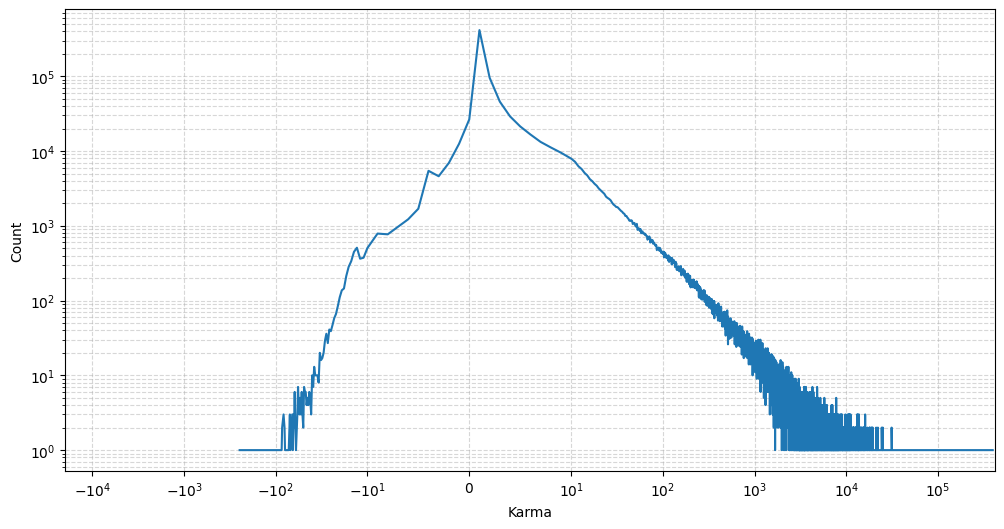

In [56]:
plt.figure(figsize=(12, 6))
plt.plot(hist_karma.index, hist_karma.values)
plt.xlabel('Karma')
plt.ylabel('Count')
plt.yscale('log')
plt.xscale('symlog', linthresh=10)
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.show()

In [58]:
df_submitted = pd.read_sql("SELECT array_length(submitted, 1) AS submitted_len FROM hacker_news.users;", engine)

min_len = df_submitted['submitted_len'].min()
max_len = df_submitted['submitted_len'].max()
avg_len = df_submitted['submitted_len'].mean()
num_null = df_submitted['submitted_len'].isnull().sum()

print(f"Min submitted list length: {min_len}")
print(f"Max submitted list length: {max_len}")
print(f"Average submitted list length: {avg_len:.2f}")
print(f"Number of users with null submitted list: {num_null}")

Min submitted list length: 1.0
Max submitted list length: 75542.0
Average submitted list length: 44.27
Number of users with null submitted list: 469


## Text

In [63]:
# Step 1: Get total number of rows with type='story'
with engine.connect() as conn:
    total_rows = conn.execute(
        text("SELECT COUNT(*) FROM hacker_news.items WHERE type = 'story'")
    ).scalar()

# Step 2: Define sample size (5% of total)
sample_fraction = 0.05
sample_size = int(total_rows * sample_fraction)

# Step 3: Sample query with filter on type
sample_query = text("""
    SELECT title FROM hacker_news.items
    WHERE type = 'story' AND random() < :fraction
    LIMIT :limit
""")

# Step 4: Execute and count characters
char_counter = Counter()

with engine.connect() as conn:
    result = conn.execution_options(stream_results=True).execute(
        sample_query,
        {"fraction": sample_fraction, "limit": sample_size}
    )
    for row in tqdm(result, desc="Processing sampled titles", total=sample_size):
        title = row[0]
        if title:
            char_counter.update(title)

# Step 5: Sort characters by count
sorted_chars = sorted(char_counter.items(), key=lambda x: -x[1])

# Step 6: Display results
print(f"Total unique characters: {len(sorted_chars)}")

# Print counts (top 20 preview)
print("\nTop 20 characters by frequency:")
for ch, count in sorted_chars[:20]:
    printable = repr(ch) if ch.isspace() or ord(ch) < 32 else ch
    print(f"{printable}: {count}")

# Print all characters as a block with newline every 100 characters
print("\nAll characters (sorted by frequency):")
char_block = ''.join(ch for ch, _ in sorted_chars)
for i in range(0, len(char_block), 100):
    print(char_block[i:i+100])

Processing sampled titles: 100%|█████████▉| 267185/267587 [00:34<00:00, 7668.40it/s]


Total unique characters: 1754

Top 20 characters by frequency:
' ': 1678520
e: 1025917
o: 748791
a: 688754
t: 679621
i: 663298
n: 637402
r: 603780
s: 570694
l: 368435
c: 285309
d: 278372
h: 265689
u: 265148
p: 210171
g: 208400
m: 203146
f: 159001
y: 152542
w: 130185

All characters (sorted by frequency):
 eoatinrslcdhupgmfywSbkAvTCPMHIDWBNRF:ELG-0O,x12.U'?VY–z)(J’Kj3594q86Q7/[]+$X“”"Zا‘&%ل|#ميروتنب;_دةس
عéف=شكه* а!جαحоеτق…иοειт—нص νıрی`ρ£üсσкزвöá~خлςىηλ€πκثطçμдóئغ@íΣضпΑуàмί»کάυİأы�ΕбγέяΠΤ•ाό{}зã​^şьй·Ο
Κظ­ωΙгร«ンา	र°कءΜδーưآलКчラđेñêน்ΓξΝ﻿ذύèä>Ρיạήीхжस่\नğΛोôảบΔχگ→إφپাΗú×רוグ网РАहώ۹۲θÜีנ！イш′âルடคĐगंāอ¿ÖミệếС
的<ัเס口コП‎ф۱øæăम्トมÇสΥژ۵ตดति‬バキц้ิịờபДБΒपβমΩすקấốッிŞể天ОМВọюζনìōでกยไפ新リ人žமНợে⁣‐å₂ลง，‪דサữ★ộšுகðהÁ│র۰ 
️ब‑„หแวÉウậ宝のГềòŽ品ćổクИ視ëΧद̶লē⁠্̇𝗲ทवא阳ュם业ắメாУự真不
ụớЗő†Θु۷⁢Â№õพ์−用婚科限≠院ש中を最何ใ安ứµù小・エரனФ比美学车ィЭ是克´一アƯদিỰ²
‍ক½ป：э州זל机公胸医ở丰і物語にか好ช无产ơ₹販ペவØ游果îـ式،私ửカ本鞋牌จЕ了©装地מโčशてまΞầभयЛΈट【】۴ºんॉב（）た𝗿𝗼色™फ款加Ə有司店玫琳凯合格整出ネジ购はืผチ財布作
چ↑↓←ブ料ピプřேХ外‏影板器țłẫ文世界服上花意通微テ大钢щ复传淘ח么シャ轉檔訊钱龙ﬁ背包下अडखしりレूくΊ電Тïুち۳जएżϊẠễैच知证がতপ𝘀𝘁情ข√代טお试验盟ủ太ベ山

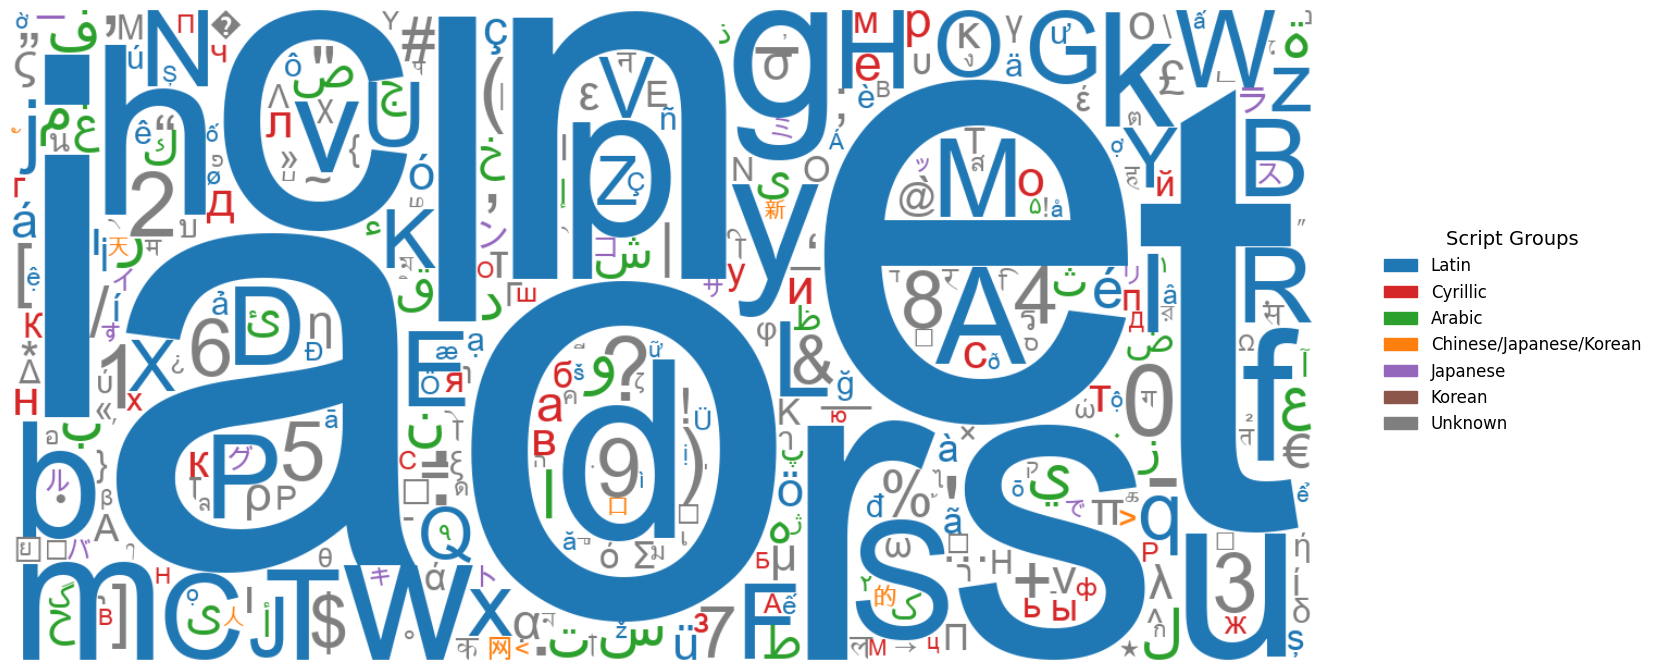

In [ ]:
# -- Helper to get script group --
def get_script_group(ch):
    try:
        name = unicodedata.name(ch)
        if 'LATIN' in name:
            return 'Latin'
        elif 'CYRILLIC' in name:
            return 'Cyrillic'
        elif 'ARABIC' in name:
            return 'Arabic'
        elif any(tag in name for tag in ['CJK', 'IDEOGRAPH', 'HAN']):
            return 'Chinese/Japanese/Korean'
        elif 'HIRAGANA' in name:
            return 'Japanese'
        elif 'KATAKANA' in name:
            return 'Japanese'
        elif 'HANGUL' in name:
            return 'Korean'
        else:
            return 'Unknown'
    except Exception:
        return 'Unknown'

# -- Color map for script groups --
group_colors = {
    'Latin': '#1f77b4',
    'Cyrillic': '#d62728',
    'Arabic': '#2ca02c',
    'Chinese/Japanese/Korean': '#ff7f0e',
    'Japanese': '#9467bd',
    'Korean': '#8c564b',
    'Unknown': '#7f7f7f',
}

# -- Apply grouping and log transform --
char_groups = {ch: get_script_group(ch) for ch in char_counter}
char_freq_log = {ch: math.log(freq + 1) for ch, freq in char_counter.items()}

# -- Color function for WordCloud --
def color_func(word, font_size, position, orientation, font_path, random_state):
    group = char_groups.get(word, 'Unknown')
    return group_colors.get(group, '#7f7f7f')

# -- Path to a Unicode font that supports all scripts --
# Update this to a valid full-path on your system
font_path = "/System/Library/Fonts/Supplemental/Arial Unicode.ttf"
if not os.path.exists(font_path):
    print("❗ Font not found. Please update `font_path` to a valid font that supports all scripts.")

# -- Generate WordCloud with all characters --
wc = WordCloud(
    width=1200,
    height=600,
    background_color='white',
    prefer_horizontal=1.0,
    font_path=font_path,
    color_func=color_func,
    max_words=400,         # <-- allow all characters
    collocations=False,
    include_numbers=True,
    normalize_plurals=False,
).generate_from_frequencies(char_freq_log)

# -- Display the WordCloud with legend on the side --
fig, ax = plt.subplots(figsize=(18, 9))
plt.subplots_adjust(right=0.85)  # Make space on the right for the legend

# Show the word cloud on the main axes
ax.imshow(wc, interpolation='bilinear')
ax.axis('off')

# Create a new axes on the side for the legend
legend_ax = fig.add_axes([0.88, 0.25, 0.1, 0.5])  # [left, bottom, width, height]
legend_ax.axis('off')

# Create legend handles
legend_handles = [
    mpatches.Patch(color=color, label=script)
    for script, color in group_colors.items()
]

# Add the legend to the new axes
legend_ax.legend(
    handles=legend_handles,
    loc='center left',
    frameon=False,
    title='Script Groups',
    fontsize=12,
    title_fontsize=14
)

plt.show()

In [23]:
def is_latin_word(word):
    try:
        return all('LATIN' in unicodedata.name(char) for char in word if char.isalpha())
    except ValueError:
        # Some chars may not have a name
        return False

def tokenize_text(text):
    # Normalize text to NFC form
    normalized_text = unicodedata.normalize('NFC', text)
    
    # Tokenize using regex to find words
    tokens = re.findall(r'\b\w+\b', normalized_text)

    tokens = [token.lower() for token in tokens]
    
    return tokens

def words_are_mostly_english(text_len, latin_words):
    if len(latin_words) < 3:
        return False

    latin_chars = sum(len(word) for word in latin_words)

    return latin_chars >= text_len / 2

def text_is_mostly_english(text):
    all_words = tokenize_text(text)
    latin_words = [word for word in all_words if is_latin_word(word)]
    return words_are_mostly_english(len(text), latin_words)


# Example usage:
print(text_is_mostly_english("Hello world, this is a test."))           # True
print(text_is_mostly_english("Привет мир, это тест."))                  # False
print(text_is_mostly_english("Hello мир test"))                         # False
print(text_is_mostly_english("Test the unicode filtering method here")) # True

True
False
False
True


In [24]:
# Step 1: Get total number of rows with type='story'
with engine.connect() as conn:
    total_rows = conn.execute(
        text("SELECT COUNT(*) FROM hacker_news.items WHERE type = 'story'")
    ).scalar()

# Step 2: Define sample size (5% of total)
sample_fraction = 0.05
sample_size = int(total_rows * sample_fraction)

# Step 3: Sample query with filter on type
sample_query = text("""
    SELECT title FROM hacker_news.items
    WHERE type = 'story' AND random() < :fraction
    LIMIT :limit
""")

non_null_text = 0
english_text_count = 0
all_words = set()
all_latin_words = set()

with engine.connect() as conn:
    result = conn.execution_options(stream_results=True).execute(
        sample_query,
        {"fraction": sample_fraction, "limit": sample_size}
    )
    for row in tqdm(result, desc="Processing sampled titles", total=sample_size):
        title = row[0]
        if title:
            non_null_text += 1

            tokens = tokenize_text(title)
            all_words.update(tokens)
            latin_words = [word for word in tokens if is_latin_word(word)]
            all_latin_words.update(latin_words)

            if words_are_mostly_english(len(title), latin_words):
                english_text_count += 1

print(f"Total samples: {sample_size}")
print(f"Total non-null titles: {non_null_text}")
print(f"Total titles with mostly English text: {english_text_count}")
print(f"Percentage of titles with mostly English text: {english_text_count / non_null_text * 100:.2f}%")
print(f"Total unique words: {len(all_words)}")
print(f"Total unique Latin words: {len(all_latin_words)}")
print(f"Percentage of Latin words: {len(all_latin_words) / len(all_words) * 100:.2f}%")

Processing sampled titles: 100%|█████████▉| 266837/267587 [01:42<00:00, 2591.02it/s]

Total samples: 267587
Total non-null titles: 244342
Total titles with mostly English text: 235761
Percentage of titles with mostly English text: 96.49%
Total unique words: 92445
Total unique Latin words: 89252
Percentage of Latin words: 96.55%


In [25]:
print("Sample of 20 words from all_latin_words:")
for i, word in enumerate(list(all_latin_words)[:20], 1):
    print(f"{i}. {word}")

Sample of 20 words from all_latin_words:
1. ansi
2. sneaking
3. unassembler
4. exipure
5. 57
6. mandelbrot
7. rootpipe
8. 995
9. soderbergh
10. supermax
11. cineworld
12. printers
13. localytics
14. txvia
15. flapping
16. provable
17. quink
18. gowebrtc
19. xtgem
20. slickaccount
